In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [3]:
alpha = np.linspace(-10,10,11).reshape((11,1))

In [4]:
aa = np.zeros((11*133,1))
for i in range(0, 133):
    aa[11*i:11*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 11, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 11, 100, 100))

In [12]:
image = 1-image/100

In [13]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [14]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [15]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [16]:
y = y.reshape((133, 11, 2, 1))

In [17]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [18]:
geometry = np.zeros((133*11,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,11):
        geometry[11*index_[0]+j,:] = np.asarray(i)

In [19]:
geometry.shape

(1463, 1)

In [20]:
geometry = geometry.reshape((133, 11, 1))

In [21]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [22]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
x_train.shape

(1386, 100, 100, 1)

In [24]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 50)      1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 50)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 125000)            0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               25000200  
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
44/44 [==============================] - 5s 13ms/step - loss: 3.1082 - rmse: 1.7630
Epoch 2/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0786 - rmse: 0.2804
Epoch 3/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0241 - rmse: 0.1552
Epoch 4/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0116 - rmse: 0.1077
Epoch 5/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0073 - rmse: 0.0855
Epoch 6/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0059 - rmse: 0.0767
Epoch 7/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0060 - rmse: 0.0777
Epoch 8/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0781
Epoch 9/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0194 - rmse: 0.1391
Epoch 10/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0068 - rmse: 0.0824
Epoch 11/5000
44/44 [=================

44/44 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0429
Epoch 86/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 87/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0447
Epoch 88/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 89/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 90/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0433
Epoch 91/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 92/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0425
Epoch 93/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0019 - rmse: 0.0435
Epoch 94/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 95/5000
44/44 [=======================

44/44 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0332
Epoch 169/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 170/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0332
Epoch 171/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0324
Epoch 172/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 173/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 174/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0555
Epoch 175/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0414
Epoch 176/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0365
Epoch 177/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0040 - rmse: 0.0630
Epoch 178/5000
44/44 [=============

44/44 [==============================] - 0s 8ms/step - loss: 8.9440e-04 - rmse: 0.0299
Epoch 252/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3740e-04 - rmse: 0.0306
Epoch 253/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8491e-04 - rmse: 0.0297
Epoch 254/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2056e-04 - rmse: 0.0303
Epoch 255/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.9340e-04 - rmse: 0.0299
Epoch 256/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4166e-04 - rmse: 0.0290
Epoch 257/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.5200e-04 - rmse: 0.0308
Epoch 258/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.2856e-04 - rmse: 0.0288
Epoch 259/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1504e-04 - rmse: 0.0285
Epoch 260/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1339e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 6.8027e-04 - rmse: 0.0261
Epoch 333/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5084e-04 - rmse: 0.0255
Epoch 334/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7344e-04 - rmse: 0.0259
Epoch 335/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.5490e-04 - rmse: 0.0275
Epoch 336/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2441e-04 - rmse: 0.0269
Epoch 337/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0019e-04 - rmse: 0.0283
Epoch 338/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7122e-04 - rmse: 0.0277
Epoch 339/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9855e-04 - rmse: 0.0282
Epoch 340/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8571e-04 - rmse: 0.0280
Epoch 341/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2212e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 6.7231e-04 - rmse: 0.0259
Epoch 413/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0633e-04 - rmse: 0.0246
Epoch 414/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.9998e-04 - rmse: 0.0223
Epoch 415/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9667e-04 - rmse: 0.0264
Epoch 416/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5205e-04 - rmse: 0.0235
Epoch 417/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.7592e-04 - rmse: 0.0218
Epoch 418/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5011e-04 - rmse: 0.0234
Epoch 419/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.6877e-04 - rmse: 0.0216
Epoch 420/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.5271e-04 - rmse: 0.0212
Epoch 421/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8352e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 3.4784e-04 - rmse: 0.0186
Epoch 493/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.1855e-04 - rmse: 0.0178
Epoch 494/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.6889e-04 - rmse: 0.0192
Epoch 495/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.0541e-04 - rmse: 0.0201
Epoch 496/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.4577e-04 - rmse: 0.0186
Epoch 497/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.0765e-04 - rmse: 0.0175
Epoch 498/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.3102e-04 - rmse: 0.0182
Epoch 499/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.2339e-04 - rmse: 0.0179
Epoch 500/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.1725e-04 - rmse: 0.0178
Epoch 501/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.5773e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 3.2671e-04 - rmse: 0.0180
Epoch 573/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.7704e-04 - rmse: 0.0166
Epoch 574/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.6723e-04 - rmse: 0.0163
Epoch 575/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.5946e-04 - rmse: 0.0161
Epoch 576/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.5661e-04 - rmse: 0.0160
Epoch 577/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.1390e-04 - rmse: 0.0177
Epoch 578/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.6175e-04 - rmse: 0.0161
Epoch 579/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.2807e-04 - rmse: 0.0151
Epoch 580/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.3503e-04 - rmse: 0.0153
Epoch 581/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.5242e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 4.4299e-04 - rmse: 0.0210
Epoch 653/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8959e-04 - rmse: 0.0262
Epoch 654/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7648e-04 - rmse: 0.0240
Epoch 655/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.3154e-04 - rmse: 0.0207
Epoch 656/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.1837e-04 - rmse: 0.0178
Epoch 657/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.3558e-04 - rmse: 0.0153
Epoch 658/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.2202e-04 - rmse: 0.0149
Epoch 659/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.1164e-04 - rmse: 0.0145
Epoch 660/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0615e-04 - rmse: 0.0143
Epoch 661/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0485e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 1.8286e-04 - rmse: 0.0135
Epoch 733/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7762e-04 - rmse: 0.0133
Epoch 734/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0911e-04 - rmse: 0.0144
Epoch 735/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0568e-04 - rmse: 0.0143
Epoch 736/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.4146e-04 - rmse: 0.0155
Epoch 737/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9754e-04 - rmse: 0.0140
Epoch 738/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9857e-04 - rmse: 0.0141
Epoch 739/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.8711e-04 - rmse: 0.0136
Epoch 740/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9219e-04 - rmse: 0.0138
Epoch 741/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.8505e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 2.1642e-04 - rmse: 0.0147
Epoch 813/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9126e-04 - rmse: 0.0138
Epoch 814/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7626e-04 - rmse: 0.0132
Epoch 815/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.7926e-04 - rmse: 0.0167
Epoch 816/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.1619e-04 - rmse: 0.0147
Epoch 817/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7114e-04 - rmse: 0.0130
Epoch 818/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0138e-04 - rmse: 0.0142
Epoch 819/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6558e-04 - rmse: 0.0128
Epoch 820/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9349e-04 - rmse: 0.0139
Epoch 821/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5498e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 1.3086e-04 - rmse: 0.0114
Epoch 893/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4939e-04 - rmse: 0.0122
Epoch 894/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6187e-04 - rmse: 0.0127
Epoch 895/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.6179e-04 - rmse: 0.0161
Epoch 896/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0330e-04 - rmse: 0.0142
Epoch 897/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7486e-04 - rmse: 0.0132
Epoch 898/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5362e-04 - rmse: 0.0124
Epoch 899/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.1402e-04 - rmse: 0.0146
Epoch 900/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7715e-04 - rmse: 0.0133
Epoch 901/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6065e-04 - rmse: 0.

44/44 [==============================] - 0s 8ms/step - loss: 1.2811e-04 - rmse: 0.0113
Epoch 973/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6545e-04 - rmse: 0.0128
Epoch 974/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5443e-04 - rmse: 0.0124
Epoch 975/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.8123e-04 - rmse: 0.0134
Epoch 976/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.0602e-04 - rmse: 0.0143
Epoch 977/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4149e-04 - rmse: 0.0119
Epoch 978/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7747e-04 - rmse: 0.0133
Epoch 979/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3579e-04 - rmse: 0.0116
Epoch 980/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6319e-04 - rmse: 0.0127
Epoch 981/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3085e-04 - rmse: 0.

Epoch 1052/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2348e-04 - rmse: 0.0111
Epoch 1053/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2661e-04 - rmse: 0.0112
Epoch 1054/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3219e-04 - rmse: 0.0115
Epoch 1055/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3547e-04 - rmse: 0.0116
Epoch 1056/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3964e-04 - rmse: 0.0118
Epoch 1057/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5062e-04 - rmse: 0.0122
Epoch 1058/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3976e-04 - rmse: 0.0118
Epoch 1059/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5626e-04 - rmse: 0.0125
Epoch 1060/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2506e-04 - rmse: 0.0111
Epoch 1061/5000
44/44 [==============================] - 0s 8ms/step - lo

44/44 [==============================] - 0s 8ms/step - loss: 1.1367e-04 - rmse: 0.0106
Epoch 1132/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0796e-04 - rmse: 0.0103
Epoch 1133/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1870e-04 - rmse: 0.0109
Epoch 1134/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3642e-04 - rmse: 0.0116
Epoch 1135/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3338e-04 - rmse: 0.0115
Epoch 1136/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6158e-04 - rmse: 0.0127
Epoch 1137/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4888e-04 - rmse: 0.0122
Epoch 1138/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7452e-04 - rmse: 0.0132
Epoch 1139/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6869e-04 - rmse: 0.0130
Epoch 1140/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4352e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 9.8644e-05 - rmse: 0.0099
Epoch 1211/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2864e-05 - rmse: 0.0096
Epoch 1212/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3017e-04 - rmse: 0.0114
Epoch 1213/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5587e-04 - rmse: 0.0124
Epoch 1214/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.8514e-04 - rmse: 0.0136
Epoch 1215/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1232e-04 - rmse: 0.0106
Epoch 1216/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3194e-04 - rmse: 0.0114
Epoch 1217/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5317e-04 - rmse: 0.0123
Epoch 1218/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1810e-04 - rmse: 0.0108
Epoch 1219/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0402e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 9.8290e-05 - rmse: 0.0099
Epoch 1290/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0560e-04 - rmse: 0.0102
Epoch 1291/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2199e-04 - rmse: 0.0110
Epoch 1292/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0684e-04 - rmse: 0.0103
Epoch 1293/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2050e-05 - rmse: 0.0095
Epoch 1294/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2380e-05 - rmse: 0.0096
Epoch 1295/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1810e-04 - rmse: 0.0108
Epoch 1296/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1465e-05 - rmse: 0.0095
Epoch 1297/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3136e-05 - rmse: 0.0096
Epoch 1298/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6452e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 1.1287e-04 - rmse: 0.0106
Epoch 1369/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1574e-04 - rmse: 0.0107
Epoch 1370/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8988e-05 - rmse: 0.0094
Epoch 1371/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2834e-04 - rmse: 0.0113
Epoch 1372/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2839e-05 - rmse: 0.0096
Epoch 1373/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8919e-05 - rmse: 0.0094
Epoch 1374/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3598e-05 - rmse: 0.0096
Epoch 1375/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2983e-04 - rmse: 0.0114
Epoch 1376/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1379e-04 - rmse: 0.0106
Epoch 1377/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0954e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 1.1377e-04 - rmse: 0.0106
Epoch 1448/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1259e-04 - rmse: 0.0106
Epoch 1449/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9598e-05 - rmse: 0.0099
Epoch 1450/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9067e-05 - rmse: 0.0088
Epoch 1451/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.7666e-05 - rmse: 0.0098
Epoch 1452/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.8124e-05 - rmse: 0.0099
Epoch 1453/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3613e-05 - rmse: 0.0096
Epoch 1454/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2302e-04 - rmse: 0.0111
Epoch 1455/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0423e-04 - rmse: 0.0102
Epoch 1456/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0883e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 1.1253e-04 - rmse: 0.0106
Epoch 1527/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1275e-04 - rmse: 0.0106
Epoch 1528/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1099e-04 - rmse: 0.0105
Epoch 1529/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8166e-05 - rmse: 0.0093
Epoch 1530/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0104e-04 - rmse: 0.0100
Epoch 1531/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2204e-04 - rmse: 0.0110
Epoch 1532/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1294e-04 - rmse: 0.0106
Epoch 1533/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0448e-04 - rmse: 0.0102
Epoch 1534/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6613e-05 - rmse: 0.0098
Epoch 1535/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9915e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 9.2619e-05 - rmse: 0.0096
Epoch 1606/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2530e-04 - rmse: 0.0112
Epoch 1607/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7950e-04 - rmse: 0.0134
Epoch 1608/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0481e-04 - rmse: 0.0224
Epoch 1609/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.0606e-04 - rmse: 0.0201
Epoch 1610/5000
44/44 [==============================] - 0s 8ms/step - loss: 2.2638e-04 - rmse: 0.0150
Epoch 1611/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.7979e-04 - rmse: 0.0134
Epoch 1612/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0064e-04 - rmse: 0.0100
Epoch 1613/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6487e-05 - rmse: 0.0093
Epoch 1614/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9354e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 9.2748e-05 - rmse: 0.0096
Epoch 1685/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3879e-04 - rmse: 0.0117
Epoch 1686/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1759e-04 - rmse: 0.0108
Epoch 1687/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0941e-04 - rmse: 0.0104
Epoch 1688/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.5843e-05 - rmse: 0.0097
Epoch 1689/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0160e-04 - rmse: 0.0100
Epoch 1690/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6405e-05 - rmse: 0.0098
Epoch 1691/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1118e-05 - rmse: 0.0095
Epoch 1692/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0540e-05 - rmse: 0.0089
Epoch 1693/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.9845e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.0681e-05 - rmse: 0.0089
Epoch 1764/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5897e-05 - rmse: 0.0092
Epoch 1765/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.7205e-05 - rmse: 0.0093
Epoch 1766/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0384e-04 - rmse: 0.0101
Epoch 1767/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1707e-04 - rmse: 0.0108
Epoch 1768/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1329e-05 - rmse: 0.0095
Epoch 1769/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.4051e-05 - rmse: 0.0096
Epoch 1770/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0899e-05 - rmse: 0.0089
Epoch 1771/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.4075e-05 - rmse: 0.0096
Epoch 1772/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0211e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 7.3138e-05 - rmse: 0.0085
Epoch 1843/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1844e-05 - rmse: 0.0090
Epoch 1844/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7010e-05 - rmse: 0.0087
Epoch 1845/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.7147e-05 - rmse: 0.0093
Epoch 1846/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0497e-04 - rmse: 0.0102
Epoch 1847/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.5629e-05 - rmse: 0.0097
Epoch 1848/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2308e-05 - rmse: 0.0096
Epoch 1849/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0041e-04 - rmse: 0.0100
Epoch 1850/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9326e-05 - rmse: 0.0099
Epoch 1851/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.4064e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 9.1022e-05 - rmse: 0.0095
Epoch 1922/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3205e-05 - rmse: 0.0096
Epoch 1923/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5171e-05 - rmse: 0.0092
Epoch 1924/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5643e-05 - rmse: 0.0092
Epoch 1925/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4091e-05 - rmse: 0.0091
Epoch 1926/5000
44/44 [==============================] - 0s 8ms/step - loss: 3.4137e-04 - rmse: 0.0184
Epoch 1927/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0040 - rmse: 0.0630
Epoch 1928/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 1929/5000
44/44 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0331
Epoch 1930/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6784e-04 - rmse: 0.025

44/44 [==============================] - 0s 8ms/step - loss: 1.3976e-04 - rmse: 0.0118
Epoch 2001/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3821e-04 - rmse: 0.0117
Epoch 2002/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2008e-04 - rmse: 0.0109
Epoch 2003/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2283e-04 - rmse: 0.0110
Epoch 2004/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1667e-04 - rmse: 0.0108
Epoch 2005/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4000e-04 - rmse: 0.0118
Epoch 2006/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1799e-04 - rmse: 0.0108
Epoch 2007/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0278e-04 - rmse: 0.0101
Epoch 2008/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1086e-04 - rmse: 0.0105
Epoch 2009/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5368e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 9.0047e-05 - rmse: 0.0094
Epoch 2080/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0655e-04 - rmse: 0.0103
Epoch 2081/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0241e-04 - rmse: 0.0101
Epoch 2082/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3301e-05 - rmse: 0.0096
Epoch 2083/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2581e-05 - rmse: 0.0096
Epoch 2084/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0007e-04 - rmse: 0.0100
Epoch 2085/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5552e-05 - rmse: 0.0092
Epoch 2086/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.8460e-05 - rmse: 0.0099
Epoch 2087/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1750e-04 - rmse: 0.0108
Epoch 2088/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0398e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 9.7622e-05 - rmse: 0.0098
Epoch 2159/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1189e-05 - rmse: 0.0095
Epoch 2160/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1298e-05 - rmse: 0.0095
Epoch 2161/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0671e-04 - rmse: 0.0103
Epoch 2162/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0437e-04 - rmse: 0.0102
Epoch 2163/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3999e-05 - rmse: 0.0096
Epoch 2164/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1458e-04 - rmse: 0.0107
Epoch 2165/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.8545e-05 - rmse: 0.0099
Epoch 2166/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5921e-05 - rmse: 0.0092
Epoch 2167/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1451e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.7090e-05 - rmse: 0.0093
Epoch 2238/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5254e-05 - rmse: 0.0092
Epoch 2239/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4957e-05 - rmse: 0.0092
Epoch 2240/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0062e-04 - rmse: 0.0100
Epoch 2241/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8159e-05 - rmse: 0.0093
Epoch 2242/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0090e-05 - rmse: 0.0089
Epoch 2243/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2669e-04 - rmse: 0.0112
Epoch 2244/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1479e-04 - rmse: 0.0107
Epoch 2245/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3275e-04 - rmse: 0.0115
Epoch 2246/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9062e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.0466e-05 - rmse: 0.0089
Epoch 2317/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3301e-05 - rmse: 0.0085
Epoch 2318/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1163e-05 - rmse: 0.0084
Epoch 2319/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.1181e-05 - rmse: 0.0095
Epoch 2320/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4896e-05 - rmse: 0.0092
Epoch 2321/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.8892e-05 - rmse: 0.0099
Epoch 2322/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3054e-04 - rmse: 0.0114
Epoch 2323/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6849e-05 - rmse: 0.0098
Epoch 2324/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6221e-05 - rmse: 0.0092
Epoch 2325/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.5752e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 1.1810e-04 - rmse: 0.0108
Epoch 2396/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0524e-04 - rmse: 0.0102
Epoch 2397/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1553e-05 - rmse: 0.0090
Epoch 2398/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0228e-04 - rmse: 0.0101
Epoch 2399/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0852e-04 - rmse: 0.0104
Epoch 2400/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6217e-05 - rmse: 0.0092
Epoch 2401/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1677e-05 - rmse: 0.0084
Epoch 2402/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6034e-05 - rmse: 0.0092
Epoch 2403/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6369e-05 - rmse: 0.0092
Epoch 2404/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7314e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.3209e-05 - rmse: 0.0091
Epoch 2475/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8211e-05 - rmse: 0.0088
Epoch 2476/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0099e-05 - rmse: 0.0089
Epoch 2477/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0113e-05 - rmse: 0.0089
Epoch 2478/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6106e-05 - rmse: 0.0098
Epoch 2479/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.3814e-05 - rmse: 0.0091
Epoch 2480/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0008e-05 - rmse: 0.0089
Epoch 2481/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7636e-05 - rmse: 0.0088
Epoch 2482/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3039e-05 - rmse: 0.0085
Epoch 2483/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7885e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.3525e-05 - rmse: 0.0091
Epoch 2554/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2989e-05 - rmse: 0.0085
Epoch 2555/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3998e-05 - rmse: 0.0079
Epoch 2556/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8657e-05 - rmse: 0.0088
Epoch 2557/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9642e-05 - rmse: 0.0089
Epoch 2558/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9538e-05 - rmse: 0.0089
Epoch 2559/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3963e-05 - rmse: 0.0085
Epoch 2560/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6477e-05 - rmse: 0.0092
Epoch 2561/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9380e-05 - rmse: 0.0089
Epoch 2562/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.7458e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.7802e-05 - rmse: 0.0093
Epoch 2633/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7073e-05 - rmse: 0.0087
Epoch 2634/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9963e-05 - rmse: 0.0083
Epoch 2635/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9179e-05 - rmse: 0.0083
Epoch 2636/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9706e-05 - rmse: 0.0099
Epoch 2637/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.6590e-05 - rmse: 0.0098
Epoch 2638/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.6649e-05 - rmse: 0.0093
Epoch 2639/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.7147e-05 - rmse: 0.0098
Epoch 2640/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0374e-05 - rmse: 0.0089
Epoch 2641/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.0466e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 1.3707e-04 - rmse: 0.0117
Epoch 2712/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.6276e-04 - rmse: 0.0127
Epoch 2713/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1738e-04 - rmse: 0.0108
Epoch 2714/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9400e-05 - rmse: 0.0099
Epoch 2715/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2579e-05 - rmse: 0.0096
Epoch 2716/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9856e-05 - rmse: 0.0089
Epoch 2717/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.2490e-05 - rmse: 0.0090
Epoch 2718/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1256e-05 - rmse: 0.0090
Epoch 2719/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0109e-05 - rmse: 0.0083
Epoch 2720/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7210e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.7188e-05 - rmse: 0.0081
Epoch 2791/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9289e-05 - rmse: 0.0076
Epoch 2792/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.0489e-05 - rmse: 0.0089
Epoch 2793/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9705e-05 - rmse: 0.0089
Epoch 2794/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0249e-05 - rmse: 0.0083
Epoch 2795/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8882e-05 - rmse: 0.0082
Epoch 2796/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2702e-05 - rmse: 0.0085
Epoch 2797/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.4674e-05 - rmse: 0.0097
Epoch 2798/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9863e-05 - rmse: 0.0089
Epoch 2799/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5203e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.5819e-05 - rmse: 0.0080
Epoch 2870/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1606e-05 - rmse: 0.0078
Epoch 2871/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.7993e-05 - rmse: 0.0093
Epoch 2872/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8640e-05 - rmse: 0.0088
Epoch 2873/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4793e-05 - rmse: 0.0086
Epoch 2874/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0113e-05 - rmse: 0.0083
Epoch 2875/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7814e-05 - rmse: 0.0088
Epoch 2876/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9176e-05 - rmse: 0.0076
Epoch 2877/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.9917e-05 - rmse: 0.0094
Epoch 2878/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2641e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 7.6302e-05 - rmse: 0.0087
Epoch 2949/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0184e-05 - rmse: 0.0077
Epoch 2950/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9232e-05 - rmse: 0.0083
Epoch 2951/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9122e-05 - rmse: 0.0082
Epoch 2952/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0366e-05 - rmse: 0.0083
Epoch 2953/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.4266e-05 - rmse: 0.0079
Epoch 2954/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4522e-04 - rmse: 0.0120
Epoch 2955/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4478e-04 - rmse: 0.0120
Epoch 2956/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.4490e-04 - rmse: 0.0120
Epoch 2957/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0244e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 6.1596e-05 - rmse: 0.0078
Epoch 3028/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1834e-05 - rmse: 0.0084
Epoch 3029/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9491e-05 - rmse: 0.0076
Epoch 3030/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4167e-05 - rmse: 0.0091
Epoch 3031/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1581e-05 - rmse: 0.0090
Epoch 3032/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0620e-04 - rmse: 0.0103
Epoch 3033/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8965e-05 - rmse: 0.0088
Epoch 3034/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3479e-05 - rmse: 0.0079
Epoch 3035/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8156e-05 - rmse: 0.0088
Epoch 3036/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5483e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.7233e-05 - rmse: 0.0075
Epoch 3107/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9597e-05 - rmse: 0.0076
Epoch 3108/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5663e-05 - rmse: 0.0074
Epoch 3109/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.4419e-05 - rmse: 0.0073
Epoch 3110/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1137e-05 - rmse: 0.0077
Epoch 3111/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1836e-05 - rmse: 0.0078
Epoch 3112/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6943e-05 - rmse: 0.0075
Epoch 3113/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3855e-05 - rmse: 0.0073
Epoch 3114/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2921e-05 - rmse: 0.0079
Epoch 3115/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9139e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 9.0745e-05 - rmse: 0.0095
Epoch 3186/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3552e-05 - rmse: 0.0085
Epoch 3187/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.7619e-05 - rmse: 0.0093
Epoch 3188/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3319e-05 - rmse: 0.0085
Epoch 3189/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.4789e-05 - rmse: 0.0080
Epoch 3190/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7381e-05 - rmse: 0.0081
Epoch 3191/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0564e-05 - rmse: 0.0083
Epoch 3192/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2830e-05 - rmse: 0.0085
Epoch 3193/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3839e-05 - rmse: 0.0079
Epoch 3194/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.5972e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 7.7504e-05 - rmse: 0.0087
Epoch 3265/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5657e-05 - rmse: 0.0080
Epoch 3266/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.4104e-05 - rmse: 0.0079
Epoch 3267/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2212e-05 - rmse: 0.0078
Epoch 3268/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7179e-05 - rmse: 0.0075
Epoch 3269/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3295e-05 - rmse: 0.0085
Epoch 3270/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7344e-05 - rmse: 0.0087
Epoch 3271/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.9439e-04 - rmse: 0.0139
Epoch 3272/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3921e-04 - rmse: 0.0117
Epoch 3273/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1671e-04 -

44/44 [==============================] - 0s 8ms/step - loss: 5.7016e-05 - rmse: 0.0075
Epoch 3344/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2315e-05 - rmse: 0.0084
Epoch 3345/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4169e-05 - rmse: 0.0085
Epoch 3346/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1911e-05 - rmse: 0.0084
Epoch 3347/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8713e-05 - rmse: 0.0082
Epoch 3348/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.5146e-05 - rmse: 0.0092
Epoch 3349/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.5190e-04 - rmse: 0.0123
Epoch 3350/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2539e-04 - rmse: 0.0111
Epoch 3351/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2947e-05 - rmse: 0.0096
Epoch 3352/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.0779e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.6934e-05 - rmse: 0.0081
Epoch 3423/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.1024e-05 - rmse: 0.0089
Epoch 3424/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0196e-04 - rmse: 0.0100
Epoch 3425/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.2120e-05 - rmse: 0.0090
Epoch 3426/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4247e-05 - rmse: 0.0091
Epoch 3427/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7558e-05 - rmse: 0.0081
Epoch 3428/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0292e-05 - rmse: 0.0077
Epoch 3429/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.0139e-05 - rmse: 0.0094
Epoch 3430/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3124e-05 - rmse: 0.0085
Epoch 3431/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4359e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.7616e-05 - rmse: 0.0082
Epoch 3502/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8766e-05 - rmse: 0.0082
Epoch 3503/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3035e-05 - rmse: 0.0085
Epoch 3504/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8241e-05 - rmse: 0.0093
Epoch 3505/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3999e-05 - rmse: 0.0085
Epoch 3506/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3310e-05 - rmse: 0.0096
Epoch 3507/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2708e-05 - rmse: 0.0085
Epoch 3508/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7989e-05 - rmse: 0.0088
Epoch 3509/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2180e-05 - rmse: 0.0084
Epoch 3510/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.8320e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.9804e-05 - rmse: 0.0083
Epoch 3581/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3467e-05 - rmse: 0.0085
Epoch 3582/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.3221e-05 - rmse: 0.0091
Epoch 3583/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.6220e-05 - rmse: 0.0087
Epoch 3584/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5780e-05 - rmse: 0.0080
Epoch 3585/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1486e-05 - rmse: 0.0084
Epoch 3586/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0585e-05 - rmse: 0.0083
Epoch 3587/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5766e-05 - rmse: 0.0080
Epoch 3588/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.5099e-05 - rmse: 0.0086
Epoch 3589/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6431e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 7.0529e-05 - rmse: 0.0083
Epoch 3660/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5115e-05 - rmse: 0.0073
Epoch 3661/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0924e-05 - rmse: 0.0071
Epoch 3662/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3013e-05 - rmse: 0.0072
Epoch 3663/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2928e-05 - rmse: 0.0079
Epoch 3664/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1363e-05 - rmse: 0.0078
Epoch 3665/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6312e-05 - rmse: 0.0074
Epoch 3666/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7590e-05 - rmse: 0.0075
Epoch 3667/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.9931e-05 - rmse: 0.0070
Epoch 3668/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.9410e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 8.9958e-05 - rmse: 0.0094
Epoch 3739/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0884e-04 - rmse: 0.0104
Epoch 3740/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0200e-04 - rmse: 0.0100
Epoch 3741/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2285e-04 - rmse: 0.0110
Epoch 3742/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7493e-05 - rmse: 0.0087
Epoch 3743/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7501e-05 - rmse: 0.0081
Epoch 3744/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5150e-05 - rmse: 0.0080
Epoch 3745/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2256e-05 - rmse: 0.0078
Epoch 3746/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1131e-05 - rmse: 0.0077
Epoch 3747/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6378e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 7.5696e-05 - rmse: 0.0086
Epoch 3818/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.9898e-05 - rmse: 0.0089
Epoch 3819/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3410e-05 - rmse: 0.0085
Epoch 3820/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1954e-05 - rmse: 0.0078
Epoch 3821/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.0333e-05 - rmse: 0.0083
Epoch 3822/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4769e-05 - rmse: 0.0086
Epoch 3823/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.9797e-05 - rmse: 0.0083
Epoch 3824/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8541e-05 - rmse: 0.0076
Epoch 3825/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0892e-05 - rmse: 0.0077
Epoch 3826/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.8999e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.8974e-05 - rmse: 0.0082
Epoch 3897/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3467e-05 - rmse: 0.0079
Epoch 3898/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7039e-05 - rmse: 0.0075
Epoch 3899/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2301e-05 - rmse: 0.0078
Epoch 3900/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5881e-05 - rmse: 0.0080
Epoch 3901/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1288e-05 - rmse: 0.0084
Epoch 3902/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.4017e-05 - rmse: 0.0079
Epoch 3903/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7824e-05 - rmse: 0.0082
Epoch 3904/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1087e-05 - rmse: 0.0077
Epoch 3905/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.3571e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.3890e-05 - rmse: 0.0079
Epoch 3976/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.0133e-05 - rmse: 0.0094
Epoch 3977/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8853e-05 - rmse: 0.0082
Epoch 3978/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5110e-05 - rmse: 0.0073
Epoch 3979/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8681e-05 - rmse: 0.0076
Epoch 3980/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2283e-04 - rmse: 0.0110
Epoch 3981/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2961e-04 - rmse: 0.0113
Epoch 3982/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8638e-05 - rmse: 0.0093
Epoch 3983/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3034e-05 - rmse: 0.0079
Epoch 3984/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7262e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.8013e-05 - rmse: 0.0082
Epoch 4055/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2055e-05 - rmse: 0.0095
Epoch 4056/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4451e-05 - rmse: 0.0091
Epoch 4057/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3230e-05 - rmse: 0.0079
Epoch 4058/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.9194e-05 - rmse: 0.0099
Epoch 4059/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.7283e-05 - rmse: 0.0098
Epoch 4060/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8134e-05 - rmse: 0.0093
Epoch 4061/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3079e-05 - rmse: 0.0085
Epoch 4062/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7091e-05 - rmse: 0.0081
Epoch 4063/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2170e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.4214e-05 - rmse: 0.0079
Epoch 4134/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5448e-05 - rmse: 0.0080
Epoch 4135/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9334e-05 - rmse: 0.0076
Epoch 4136/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7262e-05 - rmse: 0.0075
Epoch 4137/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.4961e-05 - rmse: 0.0073
Epoch 4138/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8958e-05 - rmse: 0.0076
Epoch 4139/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3326e-05 - rmse: 0.0085
Epoch 4140/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4770e-05 - rmse: 0.0086
Epoch 4141/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7046e-05 - rmse: 0.0081
Epoch 4142/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2302e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.4567e-05 - rmse: 0.0073
Epoch 4213/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8843e-05 - rmse: 0.0076
Epoch 4214/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2160e-05 - rmse: 0.0084
Epoch 4215/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6526e-05 - rmse: 0.0074
Epoch 4216/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9184e-05 - rmse: 0.0076
Epoch 4217/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0786e-05 - rmse: 0.0077
Epoch 4218/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1000e-05 - rmse: 0.0077
Epoch 4219/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3066e-05 - rmse: 0.0072
Epoch 4220/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6235e-05 - rmse: 0.0074
Epoch 4221/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.2626e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.1227e-05 - rmse: 0.0071
Epoch 4292/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.2116e-04 - rmse: 0.0109
Epoch 4293/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.1031e-04 - rmse: 0.0104
Epoch 4294/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8318e-05 - rmse: 0.0093
Epoch 4295/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.3966e-05 - rmse: 0.0085
Epoch 4296/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.3516e-05 - rmse: 0.0079
Epoch 4297/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1283e-05 - rmse: 0.0077
Epoch 4298/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1215e-05 - rmse: 0.0071
Epoch 4299/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7231e-05 - rmse: 0.0081
Epoch 4300/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9013e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.9272e-05 - rmse: 0.0076
Epoch 4371/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6136e-05 - rmse: 0.0074
Epoch 4372/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6904e-05 - rmse: 0.0075
Epoch 4373/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3290e-05 - rmse: 0.0072
Epoch 4374/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9570e-05 - rmse: 0.0076
Epoch 4375/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1778e-05 - rmse: 0.0071
Epoch 4376/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1563e-05 - rmse: 0.0071
Epoch 4377/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.8606e-05 - rmse: 0.0069
Epoch 4378/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7144e-05 - rmse: 0.0075
Epoch 4379/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2796e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.2572e-05 - rmse: 0.0072
Epoch 4450/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5628e-05 - rmse: 0.0074
Epoch 4451/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3012e-05 - rmse: 0.0072
Epoch 4452/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0747e-05 - rmse: 0.0070
Epoch 4453/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.7847e-05 - rmse: 0.0068
Epoch 4454/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.2534e-05 - rmse: 0.0072
Epoch 4455/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0500e-05 - rmse: 0.0070
Epoch 4456/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.2725e-05 - rmse: 0.0072
Epoch 4457/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.2166e-05 - rmse: 0.0071
Epoch 4458/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.9325e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.7943e-05 - rmse: 0.0082
Epoch 4529/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7772e-05 - rmse: 0.0082
Epoch 4530/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6364e-05 - rmse: 0.0074
Epoch 4531/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2971e-05 - rmse: 0.0079
Epoch 4532/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.4172e-05 - rmse: 0.0091
Epoch 4533/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.6364e-05 - rmse: 0.0087
Epoch 4534/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.4861e-05 - rmse: 0.0086
Epoch 4535/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9701e-05 - rmse: 0.0076
Epoch 4536/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8409e-05 - rmse: 0.0076
Epoch 4537/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2484e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.3877e-05 - rmse: 0.0079
Epoch 4608/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8901e-05 - rmse: 0.0082
Epoch 4609/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0031e-05 - rmse: 0.0077
Epoch 4610/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.4827e-05 - rmse: 0.0073
Epoch 4611/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0713e-05 - rmse: 0.0070
Epoch 4612/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.8549e-05 - rmse: 0.0093
Epoch 4613/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.2373e-05 - rmse: 0.0084
Epoch 4614/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.1966e-05 - rmse: 0.0084
Epoch 4615/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0386e-05 - rmse: 0.0077
Epoch 4616/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5282e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 5.6379e-05 - rmse: 0.0074
Epoch 4687/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.9342e-05 - rmse: 0.0076
Epoch 4688/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5769e-05 - rmse: 0.0080
Epoch 4689/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3348e-05 - rmse: 0.0072
Epoch 4690/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1280e-05 - rmse: 0.0071
Epoch 4691/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1506e-05 - rmse: 0.0078
Epoch 4692/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0099e-05 - rmse: 0.0077
Epoch 4693/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.7300e-05 - rmse: 0.0075
Epoch 4694/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6549e-05 - rmse: 0.0074
Epoch 4695/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2396e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 1.1350e-04 - rmse: 0.0106
Epoch 4766/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.0682e-04 - rmse: 0.0103
Epoch 4767/5000
44/44 [==============================] - 0s 8ms/step - loss: 9.2505e-05 - rmse: 0.0095
Epoch 4768/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6576e-05 - rmse: 0.0081
Epoch 4769/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.6531e-05 - rmse: 0.0074
Epoch 4770/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.8410e-05 - rmse: 0.0076
Epoch 4771/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.3233e-05 - rmse: 0.0072
Epoch 4772/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1025e-05 - rmse: 0.0070
Epoch 4773/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.2714e-05 - rmse: 0.0078
Epoch 4774/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6873e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 1.6236e-04 - rmse: 0.0127
Epoch 4845/5000
44/44 [==============================] - 0s 8ms/step - loss: 1.3685e-04 - rmse: 0.0116
Epoch 4846/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.5202e-05 - rmse: 0.0080
Epoch 4847/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0720e-05 - rmse: 0.0077
Epoch 4848/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.4502e-05 - rmse: 0.0073
Epoch 4849/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.1094e-05 - rmse: 0.0070
Epoch 4850/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.0577e-05 - rmse: 0.0070
Epoch 4851/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.8809e-05 - rmse: 0.0069
Epoch 4852/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.6919e-05 - rmse: 0.0067
Epoch 4853/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.6670e-05 -

44/44 [==============================] - 0s 8ms/step - loss: 6.5328e-05 - rmse: 0.0080
Epoch 4924/5000
44/44 [==============================] - 0s 8ms/step - loss: 7.7517e-05 - rmse: 0.0087
Epoch 4925/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.0215e-05 - rmse: 0.0077
Epoch 4926/5000
44/44 [==============================] - 0s 8ms/step - loss: 8.3981e-05 - rmse: 0.0091
Epoch 4927/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.8447e-05 - rmse: 0.0082
Epoch 4928/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.6545e-05 - rmse: 0.0081
Epoch 4929/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.7637e-05 - rmse: 0.0081
Epoch 4930/5000
44/44 [==============================] - 0s 8ms/step - loss: 6.1010e-05 - rmse: 0.0077
Epoch 4931/5000
44/44 [==============================] - 0s 8ms/step - loss: 5.5447e-05 - rmse: 0.0074
Epoch 4932/5000
44/44 [==============================] - 0s 8ms/step - loss: 4.5493e-05 -

In [28]:
time = end - start
print("Training time:", time)

Training time: 0:29:10.644196


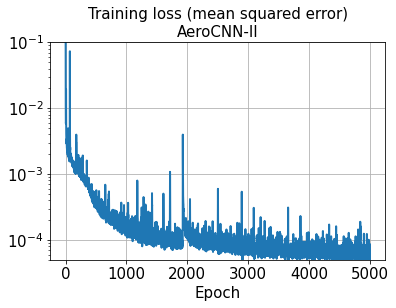

In [29]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

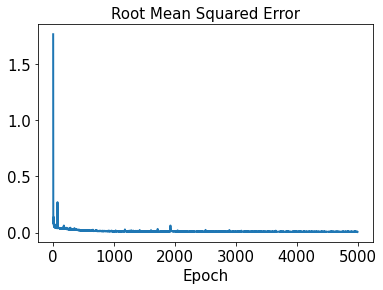

In [30]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

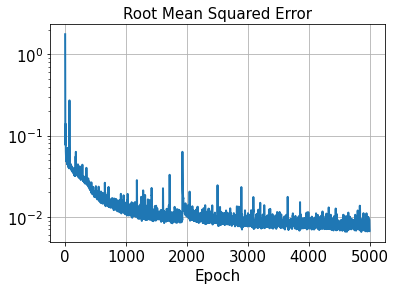

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [32]:
test_results = model.evaluate(x_train)

44/44 [==============================] - 0s 2ms/step - loss: 1.4083e-06 - rmse: 0.0000e+00


In [33]:
decoded_train = model.predict(x_train)

44/44 [==============================] - 0s 2ms/step


In [34]:
x_train.shape

(1386, 100, 100, 1)

In [35]:
decoded_test = model.predict(x_test)

3/3 [==============================] - 0s 7ms/step


In [36]:
error_train_abs = np.abs(decoded_train - y_train)

In [37]:
error_test_abs = np.abs(decoded_test - y_test)

In [38]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [39]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [40]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [41]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [42]:
decoded_train.shape

(1386, 2, 1)

In [43]:
os.chdir("D:\\TrainedModels\\20221006")
model.save('AeroCNN-II_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05(small dataset).h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.015813777653397743


In [45]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.1457866348648423


In [46]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.015127991276110602


In [47]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.06663490675939782


In [48]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.14571294610849483


In [49]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.15919074170434183


In [50]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.010283112441844206, 0.010292693863514883, 0.0059403966375575394, 0.0060309854326416916, 0.03461065740846589, 0.11260296284094612, 0.04306232286225645, 0.01327853375629701, 0.012198098468950562, 0.007402455517497945, 0.013151812522599044, 0.03165044053006099, 0.0049973823510768385, 0.0012239902584244534, 0.011536132625233125, 0.03915759705864735, 0.1369186505812344, 0.011341711327882871, 0.007619572325036907, 0.0017945485012146097, 0.000936663725314818, 0.09999301865085847, 0.011965203123748642, 0.009905396865570832, 0.008708209712905892, 0.02542099570604985, 0.04811742695903674, 0.008356829526775286, 0.011802920834927915, 0.012411081085172984, 0.004125309752441305, 0.0040199077562176125, 0.0010840782118916423, 0.009545586316879183, 0.007317543455330734, 0.00705302382627639, 0.009606080529682452, 0.006229188617552551, 0.14200989272733616, 0.02369981450552747, 0.01289005702981918, 0.010973313054726347, 0.006725049928595303, 0.004831508550307703, 0.006162021069878993, 0.002493920598455

In [51]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.03305897371899186, 0.01594108704645449, 0.05551665943093295, 0.08593174521765919, 0.05866991939692185, 0.46590001931730185, 0.17057710432533532, 0.1765014974865034, 0.11803873575442976, 0.09367402737830134, 0.4064095823290941, 0.03581559743125459, 0.025790044018075598, 0.07471943314991752, 0.3036769878454499, 0.4957524241905949, 0.09842272395457918, 0.0717868437922329, 0.011138089570670973, 0.012564323400162182, 0.0325386188936647, 0.0034140419886773275, 0.02152911320490495, 0.07211543478492208, 0.023639144609255914, 0.12618278366887606, 0.2838552277448031, 1.2733129371031338, 0.2733927014005618, 0.23460840074294267, 0.2054874990089373, 0.2271918667469428, 0.9059806876156127, 0.08715963109988915, 0.031200035852887477, 0.12662671603796216, 0.03731918142895953, 0.07803930592524866, 0.1905713261496784, 0.055556792159124235, 0.01512432748277714, 0.0820126102092868, 0.10879926948556687, 0.3710164579745035, 0.11255842900881517, 0.06022903616256958, 0.1937416693001652, 0.39723434924907824,

In [52]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.007646636128290916, 0.0016785668996019706, 0.004628042446285213, 0.005964533643755842, 0.03473368288225146, 0.10905121216209791, 0.04121334981504579, 0.008436771774663171, 0.012071845668489017, 0.005906174529784616, 0.013066583359806785, 0.028161869872936486, 0.0020822559488495717, 0.0009305070876959146, 0.010911199415760417, 0.03814097839425292, 0.13989845813891288, 0.011357640359142145, 0.007580158472096022, 9.745773593826447e-05, 0.0004816361999585384, 0.10190835168139806, 0.004095450918307688, 0.006827503921196834, 0.008679722759274013, 0.02467953834066291, 0.04469787305429852, 0.005711600837057792, 0.004158442404419482, 0.012388006195184783, 0.004090802641166009, 0.0038269590050379926, 0.0007513425835884033, 0.0071908790370527765, 0.0019821521742246387, 0.005321340413303178, 0.00960874706420766, 0.006062350259763761, 0.1441079226989828, 0.023496516247859787, 0.009658372980946076, 0.009786957618855898, 8.76212030493646e-05, 0.0041525594519966355, 0.0019693100691198302, 0.0023622

In [53]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.03142399370280979, 0.05971324215628949, 0.04788547044867547, 0.020895669984729585, 0.0036799646764498297, 0.16333776820230547, 0.24948005825464767, 0.31844480327066627, 0.063981866688298, 0.10195931115874336, 0.01912311132473747, 0.07308309112431413, 0.11219903812089954, 0.023524343525617886, 0.0859883351917734, 0.09901845037031248, 0.03811817777294038, 0.001252830535273495, 0.024196521854433113, 0.060429719543301015, 0.018406310416718395, 0.022628152262225212, 0.05012972636620712, 0.052223607484035886, 0.01836004093559713, 0.10492829548581575, 0.0769150554925809, 0.07616801803028356, 0.29598862636040824, 0.031145372605070894, 0.023870536541746184, 0.05603396216872595, 0.032447390101600186, 0.031796433834350164, 0.050190169898641813, 0.06325507410110245, 0.008369692437020498, 0.01733344463780646, 0.06349175462151968, 0.06958599769861118, 0.21914991600230613, 0.08329367020945797, 0.06110375987761402, 0.014343763761186516, 0.03217875433742642, 0.022639571178337918, 0.05777854838311316

In [54]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.008369692437020498

In [55]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.033308696439408446, 0.01603234295836385, 0.05294223395357078, 0.08602754534998254, 0.05795445888105495, 0.4737743067890571, 0.17066964099724216, 0.17651292341908287, 0.11804516857413064, 0.09374774888324722, 0.41230577482627523, 0.03568904892923829, 0.02575444857892349, 0.0747781847178405, 0.3041852119776823, 0.6881683259058419, 0.09869710036028485, 0.07184183686692289, 0.011120862494578877, 0.01250367467519949, 0.03252879959263321, 0.0033593168284489295, 0.022094475696978384, 0.0709302103075854, 0.02000985413143734, 0.1263083703710905, 0.2850305756699173, 1.2978125826456577, 0.27368079490442165, 0.23473039230098733, 0.2055324853458102, 0.22738001703472172, 0.9111067184688543, 0.06417695445626909, 0.018522051977674547, 0.12659941109819187, 0.03733098484817044, 0.07815882953135621, 0.22225220418961014, 0.05572085848650441, 0.00910887419438103, 0.07875033421168541, 0.10741625848638195, 0.3775539912041245, 0.11234880954213852, 0.06025719368476681, 0.1938778838610007, 0.3981228942137805

In [56]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.027858243483479296, 0.012288405011545381, 0.22957774996318728, 0.0382014873836091, 0.10694577106492927, 0.15084390311423454, 0.1262559195920822, 0.1667710187877981, 0.11421418286057385, 0.07807485767165205, 0.11628658598718412, 0.09846202742012422, 0.04776438485719797, 0.023122005212228708, 0.18073268966249054, 0.18472110793640173, 0.03001867044343142, 0.004190773810463513, 0.024598074814379124, 0.05210979957032515, 0.04659443180054433, 0.023263354003609814, 0.0041551899632093214, 0.10969959808476314, 0.19386328772653846, 0.03695823621080882, 0.06064933087905761, 0.29589085988307745, 0.1032313052174684, 0.02038085469030711, 0.14665425392521492, 0.11879828067424555, 0.33475347064236566, 0.3259047990295502, 0.2934478591072433, 0.1370653371899536, 0.030493185351469027, 0.04310473078376484, 0.05460675086943599, 0.013536965651572357, 0.22098451838634203, 0.3546022782723361, 0.19364648974494397, 0.08317554548589134, 0.2611022424787919, 0.017405248387958906, 0.07705927863415858, 0.07196160

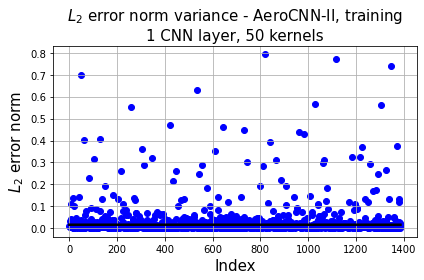

In [57]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

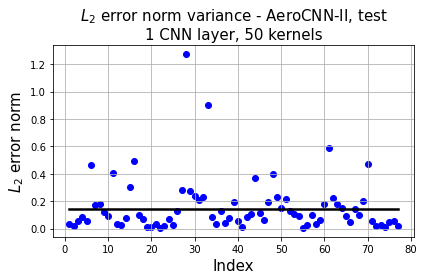

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

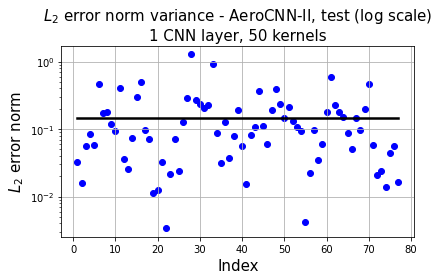

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

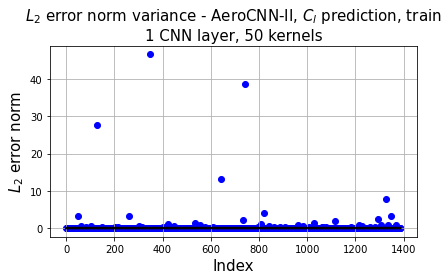

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

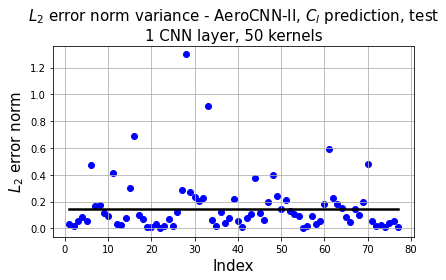

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

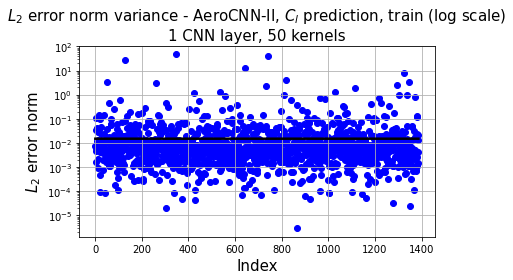

In [62]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

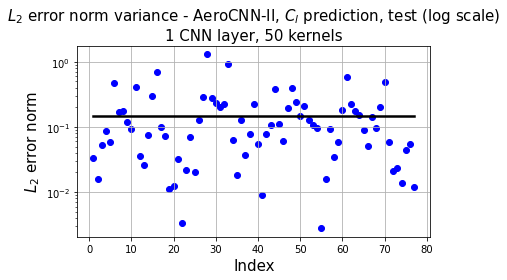

In [63]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

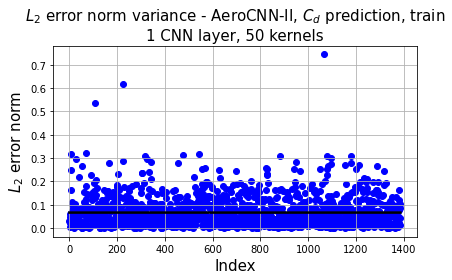

In [64]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

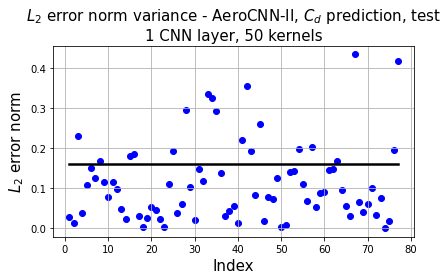

In [65]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

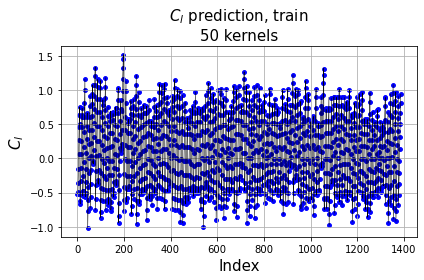

In [66]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

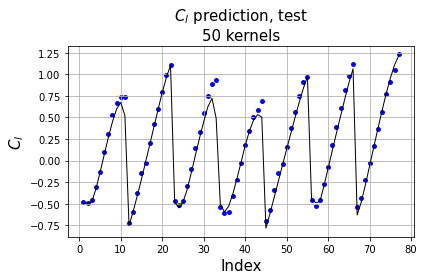

In [67]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

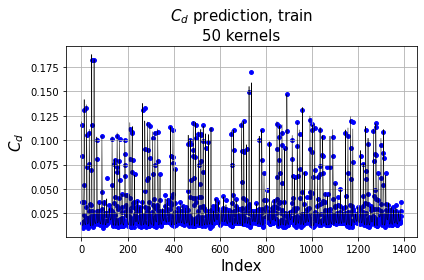

In [68]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

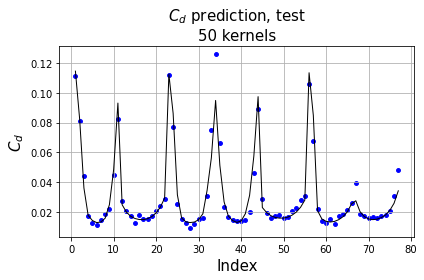

In [69]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

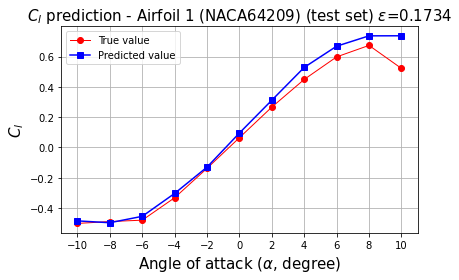

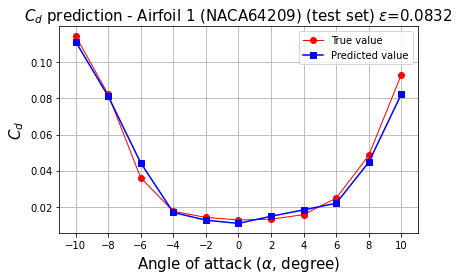

In [70]:
airfoiltest1_predict = decoded_test[11*0:11*1]

airfoiltest1_cl=y_test[11*0:11*1,0,:]
airfoiltest1_cd=y_test[11*0:11*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*11][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*11][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

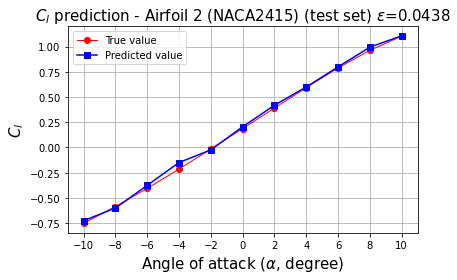

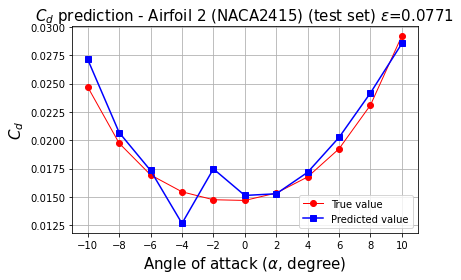

In [71]:
airfoiltest37_predict = decoded_test[11*1:11*2]

airfoiltest37_cl=y_test[11*1:11*2,0,:]
airfoiltest37_cd=y_test[11*1:11*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(11,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*11][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*11][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [72]:
mseCl = np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2)/11
mseCd = np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2)/11
print(mseCl)
print(mseCd)

0.0007717848208065626
2.2870823447844004e-06


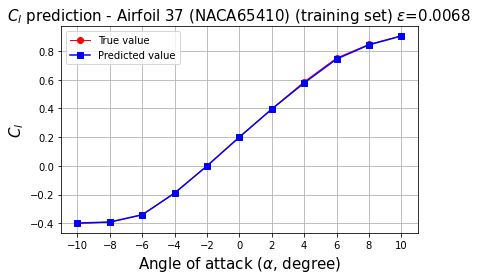

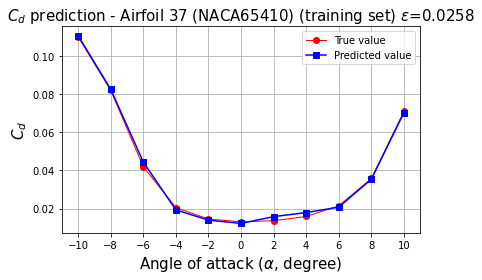

In [74]:
airfoiltrain37_predict = decoded_train[11*36:11*37]

airfoiltrain37_cl=y_train[11*36:11*37,0,:]
airfoiltrain37_cd=y_train[11*36:11*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*11][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*11][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

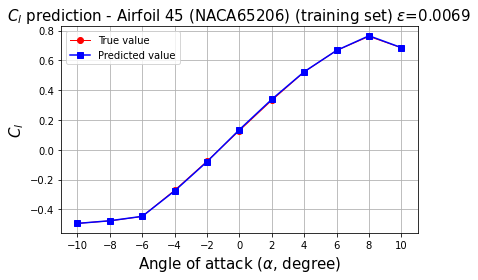

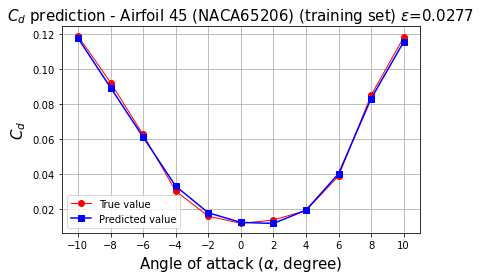

In [75]:
airfoiltrain45_predict = decoded_train[11*44:11*45]

airfoiltrain45_cl=y_train[11*44:11*45,0,:]
airfoiltrain45_cd=y_train[11*44:11*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*11][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*11][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

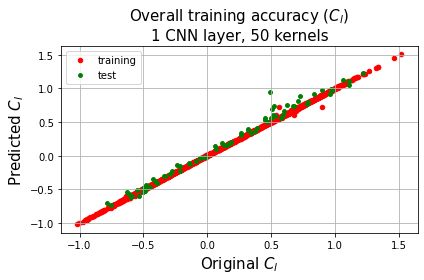

In [76]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 50 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

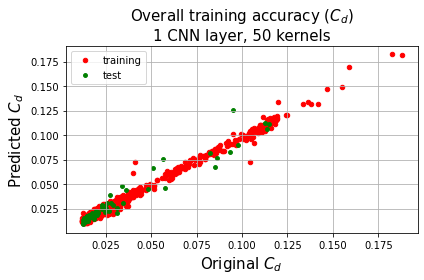

In [77]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

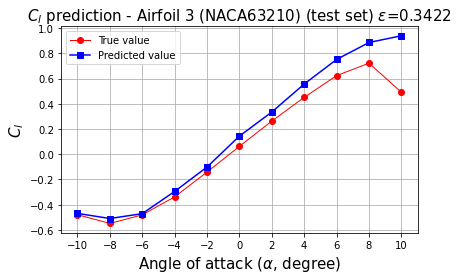

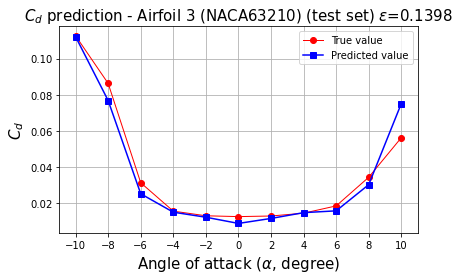

In [78]:
airfoiltest3_predict = decoded_test[11*2:11*3]

airfoiltest3_cl=y_test[11*2:11*3,0,:]
airfoiltest3_cd=y_test[11*2:11*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(11,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*11][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(11,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(11,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*11][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

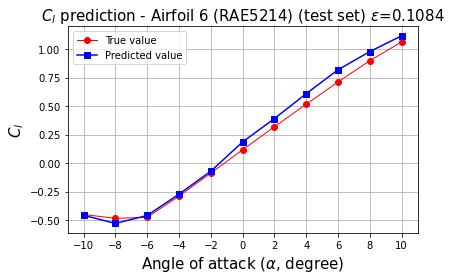

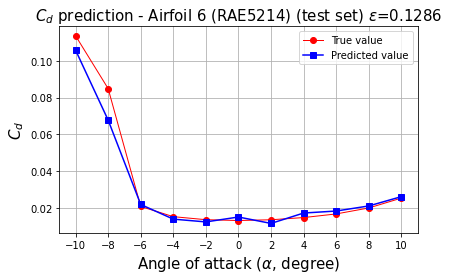

In [79]:
airfoiltest11_predict = decoded_test[11*5:11*6]

airfoiltest11_cl=y_test[11*5:11*6,0,:]
airfoiltest11_cd=y_test[11*5:11*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(11,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*11][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(11,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(11,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*11][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [80]:
from sklearn.metrics import r2_score

r2TrainCl=r2_score(y_train[:,0,:], decoded_train[:,0,:])
r2TrainCd=r2_score(y_train[:,1,:], decoded_train[:,1,:])
r2TestCl=r2_score(y_test[:,0,:], decoded_test[:,0,:])
r2TestCd=r2_score(y_test[:,1,:], decoded_test[:,1,:])

print(r2TrainCl)

print(r2TrainCd)

print(r2TestCl)

print(r2TestCd)

0.9997608789941077
0.9899927928944764
0.9775438161690126
0.9425738927763657
